This image is: <class 'numpy.ndarray'> with dimesions: (240, 320, 3)


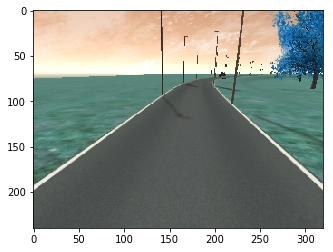

In [144]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

image = cv2.imread('../Image/center.png')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
low_threshold = 10
high_threshold = 150

# Create masked edges image
imshape = image.shape
vertices = np.array([[(int(0*imshape[1]),imshape[0]),(int(0.15*imshape[1]), 
            int(0.4*imshape[0])), (int(0.80*imshape[1]), int(0.4*imshape[0])), (
            imshape[1],imshape[0])]], dtype=np.int32)


# Define the Hough transform parameters and detect lines using it
rho = 1 # distance resolution in pixels of the Hough grid
theta = (np.pi/180) # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 60 #minimum number of pixels making up a line
max_line_gap = 30    # maximum gap in pixels between 
kernel_size = 5

In [145]:

#######Error
# blur_gray = gaussian_blur(gray, kernel_size)
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
# edges = edges = canny(blur_gray, low_threshold, high_threshold)
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
# def canny(image):
#     image_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#     blur = cv2.GaussianBlur(image_gray,(5,5),0)
#     canny = cv2.Canny(blur,50,250)
#     return canny


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with - Make a black image of the same size
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255# white
        
    #filling pixels inside the polygon defined by "vertices" with the fill color  
    # Fill the defined polygon area with white
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    # Will return only the region of interest
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

##def draw_lines(line_img, lines)
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # Function has been written to work with Challenge video as well
    # b -0, g-1, r-2 
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # At the bottom of the image, imshape[0] and top has been defined as 330
    imshape = img.shape 
    
    slope_left=0
    slope_right=0
    leftx=0
    lefty=0
    rightx=0
    righty=0
    i=0
    j=0
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope >0.1: #Left lane and not a straight line
                # Add all values of slope and average position of a line
                slope_left += slope 
                leftx += (x1+x2)/2
                lefty += (y1+y2)/2
                i+= 1
            elif slope < -0.2: # Right lane and not a straight line
                # Add all values of slope and average position of a line
                slope_right += slope
                rightx += (x1+x2)/2
                righty += (y1+y2)/2
                j+= 1
    # Left lane - Average across all slope and intercepts
    if i>0: # If left lane is detected
        avg_slope_left = slope_left/i
        avg_leftx = leftx/i
        avg_lefty = lefty/i
        # Calculate bottom x and top x assuming fixed positions for corresponding y
        xb_l = int(((int(0.97*imshape[0])-avg_lefty)/avg_slope_left) + avg_leftx)
        xt_l = int(((int(0.61*imshape[0])-avg_lefty)/avg_slope_left)+ avg_leftx)

    else: # If Left lane is not detected - best guess positions of bottom x and top x
        xb_l = int(0.21*imshape[1])
        xt_l = int(0.43*imshape[1])
    
    # Draw a line
    cv2.line(img, (xt_l, int(0.61*imshape[0])), (xb_l, int(0.97*imshape[0])), color, thickness)
    
    #Right lane - Average across all slope and intercepts
    if j>0: # If right lane is detected
        avg_slope_right = slope_right/j
        avg_rightx = rightx/j
        avg_righty = righty/j
        # Calculate bottom x and top x assuming fixed positions for corresponding y
        xb_r = int(((int(0.97*imshape[0])-avg_righty)/avg_slope_right) + avg_rightx)
        xt_r = int(((int(0.61*imshape[0])-avg_righty)/avg_slope_right)+ avg_rightx)
    
    else: # If right lane is not detected - best guess positions of bottom x and top x
        xb_r = int(0.89*imshape[1])
        xt_r = int(0.53*imshape[1])
    
    # Draw a line    
    cv2.line(img, (xt_r, int(0.61*imshape[0])), (xb_r, int(0.97*imshape[0])), color, thickness)
    yt = int(0.61*imshape[0])
    yt_l = yt
    yt_r = yt_l
    
    yb = int(0.97*imshape[0])
    yb_l = yb
    yb_r = yb_l
    #xb_l,yb_l,xt_l,yt_l,xb_r,yb_r,xt_r,yt_r
    xb_center = (xb_l + xb_r)/2
    xt_center = (xt_l+ xt_r)/2
    print(xb_center,'xb')
    print(xt_center,'xt')
    pol = np.polyfit((xb_center,xt_center),(yb,yt),1)
    ang_center = pol[0]
    ang_center = np.arctan(ang_center)*180/np.pi
    print(ang_center,"angle")
    
    
#     plt.figure()
#     plt.plot((xt_l,xb_l ), (int(0.61*imshape[0]), int(0.97*imshape[0])), color='yellow')
#     plt.scatter((xt_r,xb_r ), (int(0.61*imshape[0]), int(0.97*imshape[0])), color='green' )
#     plt.imshow(img)

In [146]:


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
#def weighted_img
def weighted_img(img, initial_img, alpha=0.8, beta=1., lamda=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha, img, beta, lamda)

In [147]:
def lane_detector(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 10
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Create masked edges image
    imshape = image.shape
    masked_edges = region_of_interest(edges, vertices)


    # Define the Hough transform parameters and detect lines using it
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180) # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 60 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments

    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    final_img = weighted_img(line_img, image, alpha=0.6, beta=1., lamda=0.)
    return edges, masked_edges, final_img
    

156.5 xb
167.5 xt
-82.71104767638985 angle


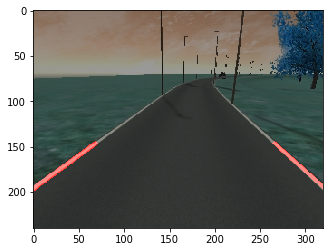

In [148]:
###Test

# ####Error
# blur_gray = gaussian_blur(gray, kernel_size)
# edges = canny(blur_gray, low_threshold, high_threshold)
# #edges = canny(image)
# masked_edges = region_of_interest(edges, vertices)
# line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
# final_img = weighted_img(line_img, image, alpha=0.6, beta=1., lamda=0.)
# plt.imshow(final_img, cmap='Greys_r')

edges, masked_edges, final_img = lane_detector(image)
plt.imshow(final_img, cmap='Greys_r')